In [1]:
from qiskit.aqua.algorithms import NumPyEigensolver#, VQE
from qiskit.algorithms import VQE
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter


from qiskit.utils import QuantumInstance, algorithm_globals

# Connect with IBMQ

In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, execute
from qiskit import execute, Aer
from qiskit.providers.ibmq import IBMQBackend, least_busy
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.ibmq import least_busy
from IPython.display import clear_output

def connect_to_ibm(simulator: bool = False) -> IBMQBackend:
    """Connect to IBMQ chip and return backend.

    Parameters
    ----------
    simulator : bool, optional
        Whether to use the simulator or the least busy IBMQ chip, by default False

    Returns
    -------
    IBMQBackend
        Backend object of the device used to run calculations
    """
    # load individual IBMQ account
    #if len(IBMQ.stored_account()) == 0:
    with open("token.txt", "r") as token_f:
        token = token_f.read()
    IBMQ.save_account(token, overwrite=True)
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

    # select backend
    if simulator:
        backend = Aer.get_backend("qasm_simulator")
    else:
        small_devices = provider.backends(filters=lambda x: not x.configuration().simulator)
        backend = least_busy(small_devices)

    print(backend)

    return backend

backend = connect_to_ibm()

ibmq_armonk


# Obtain Hamiltoians
Either from PySCF Library or hamiltonians.txt. These have different formats but are handled accordingly by the construct_reduced_hamiltonian function.

In [3]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

def get_qubit_op_2(dist):
    driver = PySCFDriver(atom="He .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=1, spin=0, basis='sto3g')
    molecule = driver.run()
    #freeze_list = [0]
    #remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    #remove_list = [x % molecule.num_orbitals for x in remove_list]
    #freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    #remove_list = [x - len(freeze_list) for x in remove_list]
    #remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    #freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    #ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    energy_shift=0
    #num_spin_orbitals -= len(freeze_list)
    #num_particles -= len(freeze_list)
    #ferOp = ferOp.fermion_mode_elimination(remove_list)
    #num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [38]:
ham = {'III':-6.823060333, 'ZII':-0.1110098029, 'IZI':-0.5370907285, 'IIZ':-0.3127149146, 
       'ZZI':0.383637914, 'ZIZ':0.2581256772, 'IZZ':0.2523178271, 'IXX':0.01764480014, 
       'IYY':0.01764480014, 'XXI':0.06593809513, 'YYI':-0.06593809513, 'XIX':0.0121680127, 'YIY':0.0121680127}

terms_noncon = c.greedy_dfs(ham, 10, criterion='weight')[-1]
ham_noncon = {p:ham[p] for p in terms_noncon}

#ham_noncon = {'III':-6.823060333, 'ZII':-0.1110098029, 'IZI':-0.5370907285, 'IIZ':-0.3127149146, 
#              'ZZI':0.383637914, 'ZIZ':0.2581256772, 'IZZ':0.2523178271, 'IXX':0.01764480014, 'IYY':0.01764480014}

#ham_con = {'XXI':0.06593809513, 'YYI':-0.06593809513, 'XIX':0.0121680127, 'YIY':0.0121680127}

#terms_noncon = ham_noncon.keys()

model = c.quasi_model(ham_noncon)
print(model,'\n')
fn_form = c.energy_function_form(ham_noncon, model)
print(fn_form, '\n')
gs_noncon = c.find_gs_noncon(ham_noncon)
print(gs_noncon, '\n')
ep_state = gs_noncon[1]
order = list(range(3)) #this can be user-specified in future
#order_ref = copy.deepcopy(order) #since get_reduced_hamiltonians empties original order
reduced_hamiltonians = c.get_reduced_hamiltonians(ham, model, fn_form, ep_state, order)
red_ham = reduced_hamiltonians[3]
print(red_ham)

vqe = CS_VQE(ham, terms_noncon, num_qubits=3, num_orbitals=6, num_particles=2)
result = NumPyEigensolver(sum([PauliOp(Pauli(k), ham[k]) for k in ham.keys()])).run()
exact_energy = np.real(result.eigenvalues)

print(vqe, exact_energy)

(['ZZI', 'IIZ'], ['XXI', 'IZI'], {'III': [[], [], 1], 'IZI': [[], ['IZI'], 1], 'ZZI': [['ZZI'], [], 1], 'IIZ': [['IIZ'], [], 1], 'ZIZ': [['ZZI', 'IIZ'], ['IZI'], 1], 'IZZ': [['IIZ'], ['IZI'], 1], 'ZII': [['ZZI'], ['IZI'], 1], 'XXI': [[], ['XXI'], 1], 'YYI': [['ZZI'], ['XXI'], (-1+0j)]}) 

[2, 2, [[-6.823060333, [], [], 'III'], [-0.5370907285, [], [1], 'IZI'], [0.383637914, [0], [], 'ZZI'], [-0.3127149146, [1], [], 'IIZ'], [0.2581256772, [0, 1], [1], 'ZIZ'], [0.2523178271, [1], [1], 'IZZ'], [-0.1110098029, [0], [1], 'ZII'], [0.06593809513, [], [0], 'XXI'], [(0.06593809513-0j), [0], [0], 'YYI']]] 

[-7.9513019373, [[-1, 1], [-2.329833053687703e-08, 0.9999999999999998]], (['ZZI', 'IIZ'], ['XXI', 'IZI'], {'III': [[], [], 1], 'IZI': [[], ['IZI'], 1], 'ZZI': [['ZZI'], [], 1], 'IIZ': [['IIZ'], [], 1], 'ZIZ': [['ZZI', 'IIZ'], ['IZI'], 1], 'IZZ': [['IIZ'], ['IZI'], 1], 'ZII': [['ZZI'], ['IZI'], 1], 'XXI': [[], ['XXI'], 1], 'YYI': [['ZZI'], ['XXI'], (-1+0j)]}), [2, 2, [[-6.823060333, [], [], 'II

In [5]:
import ast

f = open("hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

for k in hamiltonians.keys():
    print(k)

H2-S1_STO-3G_singlet
C1-O1_STO-3G_singlet
H1-Cl1_STO-3G_singlet
H1-Na1_STO-3G_singlet
H2-Mg1_STO-3G_singlet
H1-F1_3-21G_singlet
H1-Li1_3-21G_singlet
Be1_STO-3G_singlet
H1-F1_STO-3G_singlet
H1-Li1_STO-3G_singlet
Ar1_STO-3G_singlet
F2_STO-3G_singlet
H1-O1_STO-3G_singlet
H2-Be1_STO-3G_singlet
H2-O1_STO-3G_singlet
H2_3-21G_singlet
H2_6-31G_singlet
H3-N1_STO-3G_singlet
H4-C1_STO-3G_singlet
Mg1_STO-3G_singlet
N2_STO-3G_singlet
Ne1_STO-3G_singlet
O2_STO-3G_singlet
H1-Li1-O1_STO-3G_singlet
H1-He1_STO-3G_singlet
H3_STO-3G_singlet_1+
H1-He1_3-21G_singlet_1+
H3_3-21G_singlet_1+
H4-N1_STO-3G_singlet_1+


In [30]:
speciesname = 'H2_6-31G_singlet'

encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
n_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
ham = hamiltonians[speciesname][2] # full Hamiltonian
ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian

print('number of qubits:', n_qubits)
print('true ground state energy:', true_gs)
print('noncontextual approximation to ground state energy:', gs_noncon[0])
print(ham_noncon)

number of qubits: 5
true ground state energy: -1.876460203598488
noncontextual approximation to ground state energy: -1.8517678403392315
{'IIIII': 1.5293465322243227, 'ZIIII': -1.0457075312510897, 'ZZZII': -1.0457075312510897, 'ZZIIZ': 0.6881071820915262, 'ZZIZI': 0.6881071820915261, 'IIZII': -0.4055198682337698, 'IZIII': -0.4055198682337698, 'IZZII': 0.2826730025779857, 'IIIZZ': 0.27932036412726724, 'IIIIZ': -0.272118136451076, 'IIIZI': -0.272118136451076, 'ZZIZZ': -0.2665225256524458, 'ZIZII': 0.22102802962140775, 'IZZXZ': 0.08820113157758526, 'ZIZXZ': 0.08820113157758526, 'ZIIIZ': 0.07172093412363195, 'ZZZZI': 0.07172093412363195, 'IZIXZ': -0.0630080420394397, 'ZIIXZ': -0.0630080420394397, 'ZIIZI': 0.046085877231641814, 'ZZZIZ': 0.046085877231641814, 'IIZXZ': -0.03738940915377441, 'ZZZXZ': -0.03738940915377441, 'IIZZI': -0.029919945771762033, 'IZIIZ': -0.029919945771762033, 'ZZIII': -0.023944583946336667, 'IIZIZ': -0.018268981063105066, 'IZIZI': -0.018268981063105066, 'IZZXI': -0.01

In [7]:
hamiltonians[speciesname]

['JW',
 8,
 {'IIIIIIII': -5.001425458221718,
  'IIIIIIIX': -0.0005602367691690761,
  'IIIIIIIZ': 1.0104418175624195,
  'IIIIIIXI': 0.01115672755331298,
  'IIIIIIXZ': 0.0002823107691970577,
  'IIIIIIYY': -0.0018494520120760328,
  'IIIIIIZI': 1.0104418175624192,
  'IIIIIIZZ': 0.41455546243330654,
  'IIIIIXIX': -0.02906042590649248,
  'IIIIIXXI': 9.308532583860961e-05,
  'IIIIIXYY': -0.0020610093726644778,
  'IIIIIXZX': -0.015075372035589736,
  'IIIIIXZZ': -0.03495312426599749,
  'IIIIIYIY': -0.02906042590649248,
  'IIIIIYYX': 0.0020610093726644778,
  'IIIIIYZY': -0.015075372035589736,
  'IIIIIZII': -0.11536854093063532,
  'IIIIIZIZ': 0.0908717615562679,
  'IIIIIZXZ': -0.0015283726900879773,
  'IIIIIZZI': 0.09450446372057475,
  'IIIIXIXI': 0.001783048244458605,
  'IIIIXIZZ': -0.03290395741989794,
  'IIIIXXIX': 0.001407793599187085,
  'IIIIXXYY': -0.0036327021643068054,
  'IIIIXYIY': 0.001407793599187085,
  'IIIIXYYX': 0.0036327021643068054,
  'IIIIXZIZ': 0.005477331994841993,
  'IIIIXZXI'

# Construct m-qubit CS-VQE Hamiltonian

In [8]:
import cs_vqe as c
import copy
from qiskit.opflow import X, Z, I
from qiskit.opflow.primitive_ops import PauliOp

def construct_reduced_hamiltonian(ham, terms_noncon, num_qubits = 0, out_raw_dict = False) -> PauliOp:
    """Determine reduced Hamiltonian on minimal contextual subset
    
    """
    #restructure WeightedPauliOperator ham from Qiskit list [[complex, Pauli]] -> dict {str:complex}
    if str(type(ham)) == "<class 'qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator'>":
        Paulis = ham.paulis
        ham = {(p[1]).to_label():p[0] for p in Paulis}
        
    #Leave if already in correct format
    elif str(type(ham)) == "<class 'dict'>":
        pass
    
    #Reserved for alternative formats
    else:
        raise Exception("Unrecognised Hamiltonian Format")
            
    #Find largest noncontextual subset
    #terms_noncon = c.greedy_dfs(ham, 10, criterion='weight')[-1]
    ham_noncon = {p:ham[p] for p in terms_noncon}
    
    #Contrusct epistricted model
    model = c.quasi_model(ham_noncon)
    fn_form = c.energy_function_form(ham_noncon, model)
    gs_noncon = c.find_gs_noncon(ham_noncon)
    ep_state = gs_noncon[1]
    
    if num_qubits == 0:
        return [], gs_noncon[0]
    
    elif num_qubits == len(model[0][0]):
        return sum([PauliOp(Pauli(k), ham[k]) for k in ham.keys()]), gs_noncon[0]
    
    else:
        #Determine contextual subspace Hamiltonians
        order = list(range(len(model[0][0]))) #this can be user-specified in future
        order_ref = copy.deepcopy(order) #since get_reduced_hamiltonians empties original order
        reduced_hamiltonians = c.get_reduced_hamiltonians(ham, model, fn_form, ep_state, order)
        red_ham = reduced_hamiltonians[num_qubits]

        if out_raw_dict == True:
            return red_ham, gs_noncon[0]
        else:
            #return WeightedPauliOperator([[red_ham[k], Pauli(k)] for k in red_ham.keys()]), gs_noncon[0]
            return sum([PauliOp(Pauli(k), red_ham[k]) for k in red_ham.keys()]), gs_noncon[0]            

In [9]:
def CS_VQE(ham, terms_noncon, num_qubits, num_orbitals, num_particles, shift=0, 
           backend=BasicAer.get_backend("statevector_simulator"), optimizer = SLSQP(maxiter=20)):
    """
    """
    red_ham, gs_approx = construct_reduced_hamiltonian(ham, terms_noncon, num_qubits)
    
    if num_qubits == 0:
        return gs_approx + shift
    
    else:
        """
        initial_state = HartreeFock(
            num_orbitals=num_orbitals,
            num_particles=num_particles,
            qubit_mapping='parity')
        #print(initial_state.construct_circuit(mode='vector'))

        var_form = UCCSD(
            num_orbitals=num_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity')

        ent_map = var_form.get_entangler_map('full', num_qubits)
        ansatz = TwoLocal(num_qubits, 'ry', 'cx', ent_map, reps=2, insert_barriers=True)
        """
        alpha = Parameter('α')
        beta  = Parameter('β')
              
        anz = QuantumCircuit(3)
        
        anz.x(0), anz.x(1), anz.x(2)
        
        anz.barrier()
        
        anz.sdg(1)
        anz.h(0), anz.h(1)
        anz.cx(0, 1)
        anz.rz(2 * alpha, 1)
        anz.cx(0, 1)
        anz.h(0), anz.h(1)
        anz.s(1)
        
        anz.barrier()
        
        anz.sdg(2)
        anz.h(0), anz.h(2)
        anz.cx(0, 2)
        anz.rz(2 * beta,2)
        anz.cx(0, 2)
        anz.h(0), anz.h(2)
        anz.s(2)

        print(anz.draw())
        
        seed = 50
        algorithm_globals.random_seed = seed
        qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
        
        slsqp = SLSQP(maxiter=30)
        vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
        #vqe_result = np.real(vqe.run(backend)['eigenvalue']) + shift
        vqe_run    = vqe.compute_minimum_eigenvalue(operator=red_ham)
        vqe_result = vqe_run.optimal_value# + shift

        return vqe_result

In [10]:
alpha = Parameter('α')
beta  = Parameter('β')

anz = QuantumCircuit(3)

anz.x(0), anz.x(1), anz.x(2)

anz.barrier()

anz.sdg(1)
anz.h(0), anz.h(1)
anz.cx(0, 1)
anz.rz(2 * alpha, 1)
anz.cx(0, 1)
anz.h(0), anz.h(1)
anz.s(1)

anz.barrier()

anz.sdg(2)
anz.h(0), anz.h(2)
anz.cx(0, 2)
anz.rz(2 * beta,2)
anz.cx(0, 2)
anz.h(0), anz.h(2)
anz.s(2)

print(anz.draw())

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

#ham_noncon = {'III':-6.823060333, 'ZII':-0.1110098029, 'IZI':-0.5370907285, 'IIZ':-0.3127149146, 
#              'ZZI':0.383637914, 'ZIZ':0.2581256772, 'IZZ':0.2523178271, 'IXX':0.01764480014, 'IYY':0.01764480014}

#ham_con = {'XXI':0.06593809513, 'YYI':-0.06593809513, 'XIX':0.0121680127, 'YIY':0.0121680127}

ham = {'III':-6.823060333, 'ZII':-0.1110098029, 'IZI':-0.5370907285, 'IIZ':-0.3127149146, 
       'ZZI':0.383637914, 'ZIZ':0.2581256772, 'IZZ':0.2523178271, 'IXX':0.01764480014, 
       'IYY':0.01764480014, 'XXI':0.06593809513, 'YYI':-0.06593809513, 'XIX':0.0121680127, 'YIY':0.0121680127}

ham = sum([PauliOp(Pauli(k), ham[k]) for k in ham.keys()])

result = NumPyEigensolver(ham).run()
exact_energy = np.real(result.eigenvalues)

slsqp = SLSQP(maxiter=20)
vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham)
vqe_result = vqe_run.optimal_value

print(vqe_result, exact_energy)

     ┌───┐ ░  ┌───┐                           ┌───┐      ░  ┌───┐           »
q_0: ┤ X ├─░──┤ H ├────────■───────────────■──┤ H ├──────░──┤ H ├────────■──»
     ├───┤ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────┐┌─┴─┐├───┤┌───┐ ░  └───┘        │  »
q_1: ┤ X ├─░─┤ SDG ├┤ H ├┤ X ├┤ RZ(2*α) ├┤ X ├┤ H ├┤ S ├─░───────────────┼──»
     ├───┤ ░ └─────┘└───┘└───┘└─────────┘└───┘└───┘└───┘ ░ ┌─────┐┌───┐┌─┴─┐»
q_2: ┤ X ├─░─────────────────────────────────────────────░─┤ SDG ├┤ H ├┤ X ├»
     └───┘ ░                                             ░ └─────┘└───┘└───┘»
«                     ┌───┐     
«q_0: ─────────────■──┤ H ├─────
«                  │  └───┘     
«q_1: ─────────────┼────────────
«     ┌─────────┐┌─┴─┐┌───┐┌───┐
«q_2: ┤ RZ(2*β) ├┤ X ├┤ H ├┤ S ├
«     └─────────┘└───┘└───┘└───┘
-7.952197416866345 [-7.95219971]


In [102]:
pre_ham = {(p[1]).to_label():p[0] for p in get_qubit_op_2(1)[0].paulis}
terms_noncon = (c.greedy_dfs(pre_ham, 10, criterion='weight'))[-1]
terms_noncon

['II', 'IZ', 'ZI', 'ZZ', 'IX', 'ZX']

In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

distances = np.arange(0.5, 4, 0.1)
exact_energies = []
vqe_energies_0 = []
vqe_energies_1 = []
vqe_energies_2 = []
vqe_energies_3 = []
vqe_energies_4 = []

for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op_2(dist)
    
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    #print(exact_energies[-1])
    
    vqe_result_0 = CS_VQE(qubitOp, terms_noncon, 0, num_spin_orbitals, num_particles, shift=shift)
    vqe_energies_0.append(vqe_result_0)
    #print("0 done", vqe_result_0)
    
    #vqe_result_1 = CS_VQE(qubitOp, terms_noncon, 1, num_spin_orbitals, num_particles, shift=shift)#, backend=backend)
    #vqe_energies_1.append(vqe_result_1)
    #print("1 done", vqe_result_1)
    
    vqe_result_2 = CS_VQE(qubitOp, terms_noncon, 2, num_spin_orbitals, num_particles, shift=shift)#, backend=backend)
    vqe_energies_2.append(vqe_result_2)
    #print("2 done", vqe_result_2)
    
    #vqe_result_3 = CS_VQE(qubitOp, terms_noncon, 3, num_spin_orbitals, num_particles, shift=shift)#, backend=backend)
    #vqe_energies_3.append(vqe_result_3)
    #print("3 done", vqe_result_3)
    
    #vqe_result_4 = CS_VQE(qubitOp, terms_noncon, 4, num_spin_orbitals, num_particles, shift=shift)#, backend=backend)
    #vqe_energies_4.append(vqe_result_4)
    #print("4 done", vqe_result_4)
    
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result_2, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

KeyError: 'III'

In [ ]:
ON IMBQ Device: Interatomic Distance: 2 VQE Result: -7.728168138392638 Exact Energy: [-7.86015321]

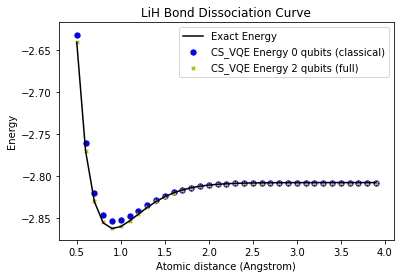

In [107]:
plt.plot(distances, exact_energies, label="Exact Energy", color='black')
plt.scatter(distances, vqe_energies_0, color='b',marker='o',s=28, label="CS_VQE Energy 0 qubits (classical)")
#plt.scatter(distances, vqe_energies_1, color='g',marker='d',s=20, label="CS_VQE Energy 1 qubits")
plt.scatter(distances, vqe_energies_2, color='y',marker='x',s=12, label="CS_VQE Energy 2 qubits (full)")
#plt.scatter(distances, vqe_energies_3, color='c',marker='x',s=12, label="CS_VQE Energy 3 qubits")
#plt.scatter(distances, vqe_energies_4, color='m',marker='x',s=12, label="CS_VQE Energy 4 qubits (full)")
#plt.scatter(distances, vqe_energies, label="VQE Energy",marker='x')

#plt.xlim([0.5, 3.5])
#plt.ylim([-7.9, -7.6])
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.title('LiH Bond Dissociation Curve')


plt.savefig("HeH+ CS_VQE qubit comparisons.png", dpi=300)
plt.show()

In [144]:
construct_reduced_hamiltonian(qubitOp, 3)

(<qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator at 0x7fba368407f0>,
 -7.830905584637077)

In [26]:
n_qubits = 4
true_gs = -7.86015321
order = [0, 1, 2, 3]

csvqe = c.csvqe_approximations_heuristic(ham, ham_noncon, n_qubits, true_gs)
print(c.contextual_subspace_approximations(ham, model, fn_form, ep_state, order))

print('true ground state energy:', csvqe[0], '\n')
print('CS-VQE approximations:', [c+shift for c in csvqe[1]], '\n')
print('CS-VQE errors:', [csvqe[2]+shift], '\n')
print('chosen order:', csvqe[3])

[-0.960490906211567, -0.96049094, -0.9604912, -0.9668129, -0.989739]
true ground state energy: -7.86015321 

CS-VQE approximations: [-7.830905584637077, -7.830905560822208, -7.834841911167819, -7.855121795506198, -7.860153321594913] 

CS-VQE errors: [array([ 2.92476254e-02,  2.92476492e-02,  2.53112988e-02,  5.03141449e-03,
       -1.11594913e-07])] 

chosen order: [1, 3, 0, 2]


In [107]:
red_ham = reduced_hamiltonians[4]
reconstruct_Qham = WeightedPauliOperator([[red_ham[k], Pauli(k)] for k in red_ham.keys()])
reconstruct_Qham.num_qubits

4

In [4]:
g = globals()

initial_state = HartreeFock(
        num_orbitals=6,
        num_particles=2,
        qubit_mapping='parity')
print(initial_state.construct_circuit(mode='vector'))

var_form = UCCSD(
        num_orbitals=6,
        num_particles=2,
        initial_state=initial_state,
        qubit_mapping='parity')

for q in range(1,6):
    g['ent_map_{0}'.format(q)] = var_form.get_entangler_map('sca', q)
    g['ansatz_{}'.format(q)]  = TwoLocal(q, 'ry', 'cx', g['ent_map_{0}'.format(q)], reps=1, insert_barriers=True)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [58]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

theta = Parameter('θ')

anz = QuantumCircuit(2)
anz.sdg(1)
anz.h(0), anz.h(1)
anz.cx(0, 1)
anz.rz(2 * theta,1)
anz.cx(0, 1)
anz.h(0), anz.h(1)
anz.s(1)

anz.num_qubits

2

In [56]:
type(anz)

qiskit.circuit.quantumcircuit.QuantumCircuit

In [133]:
str(type({p:ham[p] for p in terms_noncon}))

"<class 'dict'>"

In [62]:
from qiskit.opflow import X, Z, I

H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

In [63]:
type(H2_op)

qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp

qiskit.quantum_info.operators.symplectic.pauli.Pauli